#### Temperature teleconnection NINO

In [1]:
# Imports 
import xarray as xr
import numpy as np
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# Read in CMIP6 EP and CP temperature regressions 
EP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_EP_temp_regressions')
CP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_CP_temp_regressions')

In [3]:
# 20CR EP and CP temperature regressions 

# Read in the quadratically detrended 20CR temp
temp = xr.open_dataarray('/g/data/w40/rl5183/20CR_tmp_ensemble_mean_quad_detrend_1.5x1.5.nc')
# Calculate anomalies
clim = temp.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = (temp.groupby('time.month') - clim)
# Take DJF average
quarterly_anom = anom.resample(time='QS-DEC').mean('time')
djf_anom = quarterly_anom.isel(time=slice(0,None,4))
# NINO indices from Hadisst
sst = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc').sst.sel(lat=slice(-15,15)).sel(lon=slice(140,280))
# Detrend 
sst_detrend = np.apply_along_axis(func.quad_detrend, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)
# Calculate EP and CP index
nino3 = func.nino3_index(sst_dt, '1979-01', '2008-12')
nino4 = func.nino4_index(sst_dt, '1979-01', '2008-12')
# Calculate EP and CP index
EP_sst = (nino3 - 0.5*nino4).sel(time=slice('1900-01', '2014-12'))
CP_sst = (nino4 - 0.5*nino3).sel(time=slice('1900-01', '2014-12'))
# Take DJF average of EP index and CP index
quarterly_EP = EP_sst.resample(time='QS-DEC').mean('time')
djf_EP = quarterly_EP.isel(time=slice(0,None,4))

quarterly_CP = CP_sst.resample(time='QS-DEC').mean('time')
djf_CP = quarterly_CP.isel(time=slice(0,None,4))
# Regression
EP_regress_20CR = func.regress_nino(djf_anom, djf_EP)
CP_regress_20CR = func.regress_nino(djf_anom, djf_CP)

In [4]:
# Sign comparison 
EP_sign_list = []
for m in EP_regressions.model:
    EP_sign_list.append(func.sign_corr(EP_regressions.sel(model=m), EP_regress_20CR))
EP_sign = xr.DataArray(EP_sign_list, dims=EP_regressions.dims, coords=EP_regressions.coords)

In [5]:
CP_sign_list = []
for m in CP_regressions.model:
    CP_sign_list.append(func.sign_corr(CP_regressions.sel(model=m), CP_regress_20CR))
CP_sign = xr.DataArray(CP_sign_list, dims=CP_regressions.dims, coords=CP_regressions.coords)

In [6]:
def bincount(data):
    data = xr.DataArray(data)
    try:
        count = np.bincount(data)[0] + np.bincount(data)[1]
    except:
        count = np.bincount(data)[0]
    return count 

In [7]:
EP_bins = np.apply_along_axis(bincount, EP_sign.get_axis_num('model'), EP_sign)
CP_bins = np.apply_along_axis(bincount, CP_sign.get_axis_num('model'), CP_sign)

In [8]:
EP_percent = (EP_bins/20)*100
CP_percent = (CP_bins/20)*100

In [9]:
EP_percent = xr.DataArray(EP_percent, dims=EP_regress_20CR.dims, coords=EP_regress_20CR.coords)
CP_percent = xr.DataArray(CP_percent, dims=EP_regress_20CR.dims, coords=EP_regress_20CR.coords)

Text(0, 0.5, '%')

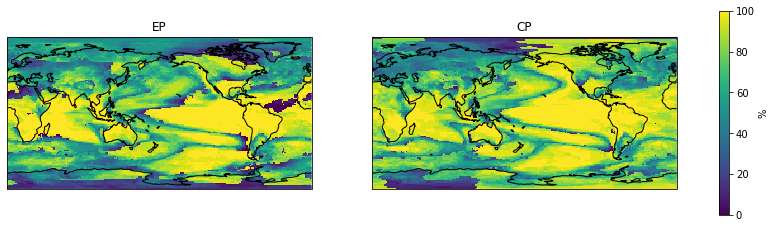

In [10]:
fig = plt.figure(figsize = (15,5)) 
axs = []
ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
im = EP_percent.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP')
axs.append(ax)
ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
im = CP_percent.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
cbar.ax.set_ylabel('%', fontsize=10)

#plt.savefig('model_agreement_temp_nino', bbox_inches='tight', dpi=300)

#### Temperature teleconnection EOF

In [11]:
# Read in CMIP6 EP and CP temperature regressions NINO
EP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_E_temp_regressions')
CP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_C_temp_regressions')

In [12]:
EP_regressions_new = []
for m in EP_regressions.model:
    if EP_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        EP_regressions_new.append(EP_regressions.sel(model=m)*-1)
    else: EP_regressions_new.append(EP_regressions.sel(model=m))
EP_regressions = xr.concat(EP_regressions_new, dim='model')

In [13]:
CP_regressions_new = []
for m in CP_regressions.model:
    if CP_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        CP_regressions_new.append(CP_regressions.sel(model=m)*-1)
    else: CP_regressions_new.append(CP_regressions.sel(model=m))
CP_regressions = xr.concat(CP_regressions_new, dim='model')

In [14]:
# 20CR regressions with EOF
# Calculate anomalies 
had_clim = sst_dt.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
had_anom = sst_dt.sel(time=slice('1900-01', '2014-12')).groupby('time.month') - had_clim
# EOFs
had_eof, had_pcs, had_var = func.eof_and_pcs(had_anom, 3)
# Scale PCs to have a standrd deviation of 1 
had_pc1 = (had_pcs.sel(mode=1)/had_pcs.sel(mode=1).std())*-1
had_pc2 = had_pcs.sel(mode=2)/had_pcs.sel(mode=2).std()
# Calculate E-index and C-index
had_E = (had_pc1 - had_pc2)/np.sqrt(2)
had_C = (had_pc1 + had_pc2)/np.sqrt(2)
# Take DJF average of E-index and C-index
had_quarterly_E = had_E.resample(time='QS-DEC').mean('time')
had_djf_E = had_quarterly_E.isel(time=slice(0,None,4))

had_quarterly_C = had_C.resample(time='QS-DEC').mean('time')
had_djf_C = had_quarterly_C.isel(time=slice(0,None,4))

# Regression
EP_regress_20CR = func.regress_nino(djf_anom, had_djf_E)
CP_regress_20CR = func.regress_nino(djf_anom, had_djf_C)

In [15]:
# Sign comparison 
EP_sign_list = []
for m in EP_regressions.model:
    EP_sign_list.append(func.sign_corr(EP_regressions.sel(model=m), EP_regress_20CR))
EP_sign = xr.DataArray(EP_sign_list, dims=EP_regressions.dims, coords=EP_regressions.coords)

In [16]:
CP_sign_list = []
for m in CP_regressions.model:
    CP_sign_list.append(func.sign_corr(CP_regressions.sel(model=m), CP_regress_20CR))
CP_sign = xr.DataArray(CP_sign_list, dims=CP_regressions.dims, coords=CP_regressions.coords)

In [17]:
EP_bins = np.apply_along_axis(bincount, EP_sign.get_axis_num('model'), EP_sign)
CP_bins = np.apply_along_axis(bincount, CP_sign.get_axis_num('model'), CP_sign)

In [18]:
EP_percent = (EP_bins/20)*100
CP_percent = (CP_bins/20)*100

In [19]:
EP_percent = xr.DataArray(EP_percent, dims=EP_regress_20CR.dims, coords=EP_regress_20CR.coords)
CP_percent = xr.DataArray(CP_percent, dims=EP_regress_20CR.dims, coords=EP_regress_20CR.coords)

Text(0, 0.5, '%')

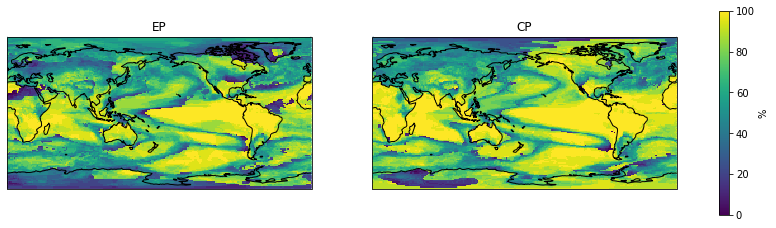

In [20]:
fig = plt.figure(figsize = (15,5)) 
axs = []
ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
im = EP_percent.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP')
axs.append(ax)
ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
im = CP_percent.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
cbar.ax.set_ylabel('%', fontsize=10)

#plt.savefig('model_agreement_temp_eof', bbox_inches='tight', dpi=300)

#### Precipitation teleconnection NINO

In [21]:
EP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_EP_pr_regressions')
CP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_CP_pr_regressions')

In [22]:
# 20CR EP and CP temperature regressions
# Read in the 20CR precip
precip = xr.open_dataarray('/g/data/w40/rl5183/20CR_pr_ensemble_mean_1.5x1.5.nc').sel(time=slice('1900-01', '2014-12'))*86400
# Calculate anomalies
clim = precip.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = (precip.groupby('time.month') - clim)
# Take DJF average
quarterly_anom = anom.resample(time='QS-DEC').mean('time')
djf_anom = quarterly_anom.isel(time=slice(0,None,4))
# Regression
EP_regress_20CR = func.regress_nino(djf_anom, djf_EP)
CP_regress_20CR = func.regress_nino(djf_anom, djf_CP)

In [23]:
# Sign comparison 
EP_sign_list = []
for m in EP_regressions.model:
    EP_sign_list.append(func.sign_corr(EP_regressions.sel(model=m), EP_regress_20CR))
EP_sign = xr.DataArray(EP_sign_list, dims=EP_regressions.dims, coords=EP_regressions.coords)

In [24]:
CP_sign_list = []
for m in CP_regressions.model:
    CP_sign_list.append(func.sign_corr(CP_regressions.sel(model=m), CP_regress_20CR))
CP_sign = xr.DataArray(CP_sign_list, dims=CP_regressions.dims, coords=CP_regressions.coords)

In [25]:
EP_bins = np.apply_along_axis(bincount, EP_sign.get_axis_num('model'), EP_sign)
CP_bins = np.apply_along_axis(bincount, CP_sign.get_axis_num('model'), CP_sign)

In [26]:
EP_percent = (EP_bins/19)*100
CP_percent = (CP_bins/19)*100

In [27]:
EP_percent = xr.DataArray(EP_percent, dims=EP_regress_20CR.dims, coords=EP_regress_20CR.coords)
CP_percent = xr.DataArray(CP_percent, dims=EP_regress_20CR.dims, coords=EP_regress_20CR.coords)

Text(0, 0.5, '%')

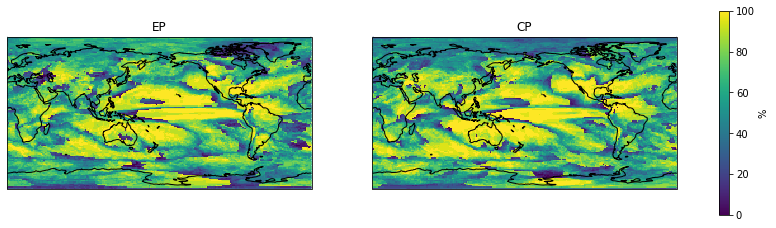

In [28]:
fig = plt.figure(figsize = (15,5)) 
axs = []
ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
im = EP_percent.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP')
axs.append(ax)
ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
im = CP_percent.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
cbar.ax.set_ylabel('%', fontsize=10)

#plt.savefig('model_agreement_precip_nino', bbox_inches='tight', dpi=300)

#### Precipitation teleconnection EOF

In [29]:
EP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_E_pr_regressions')
CP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_C_pr_regressions')

In [30]:
EP_regressions_new = []
for m in EP_regressions.model:
    if m == 'ACCESS-CM2' or m == 'BCC-CSM2-MR' or m == 'GFDL-ESM4' or m == 'INM-CM4-8' or m == 'INM-CM5-0' or m == 'KACE-1-0-G' or m == 'MIROC6' or m == 'MPI-ESM1-2-HR' or m == 'MRI-ESM2-0' or m == 'NorESM2-LM' or m == 'NorESM2-MM':
        EP_regressions_new.append(EP_regressions.sel(model=m)*-1)
    else: EP_regressions_new.append(EP_regressions.sel(model=m))
EP_regressions = xr.concat(EP_regressions_new, dim='model')

In [31]:
CP_regressions_new = []
for m in CP_regressions.model:
    if m == 'ACCESS-CM2' or m == 'BCC-CSM2-MR' or m == 'GFDL-ESM4' or m == 'INM-CM4-8' or m == 'INM-CM5-0' or m == 'KACE-1-0-G' or m == 'MIROC6' or m == 'MPI-ESM1-2-HR' or m == 'MRI-ESM2-0' or m == 'NorESM2-LM' or m == 'NorESM2-MM':
        CP_regressions_new.append(CP_regressions.sel(model=m)*-1)
    else: CP_regressions_new.append(CP_regressions.sel(model=m))
CP_regressions = xr.concat(CP_regressions_new, dim='model')

In [32]:
# 20CR regression
EP_regress_20CR = func.regress_nino(djf_anom, had_djf_E)
CP_regress_20CR = func.regress_nino(djf_anom, had_djf_C)

In [33]:
# Sign comparison 
EP_sign_list = []
for m in EP_regressions.model:
    EP_sign_list.append(func.sign_corr(EP_regressions.sel(model=m), EP_regress_20CR))
EP_sign = xr.DataArray(EP_sign_list, dims=EP_regressions.dims, coords=EP_regressions.coords)

In [34]:
CP_sign_list = []
for m in CP_regressions.model:
    CP_sign_list.append(func.sign_corr(CP_regressions.sel(model=m), CP_regress_20CR))
CP_sign = xr.DataArray(CP_sign_list, dims=CP_regressions.dims, coords=CP_regressions.coords)

In [35]:
EP_bins = np.apply_along_axis(bincount, EP_sign.get_axis_num('model'), EP_sign)
CP_bins = np.apply_along_axis(bincount, CP_sign.get_axis_num('model'), CP_sign)

In [36]:
EP_percent = (EP_bins/19)*100
CP_percent = (CP_bins/19)*100

In [37]:
EP_percent = xr.DataArray(EP_percent, dims=EP_regress_20CR.dims, coords=EP_regress_20CR.coords)
CP_percent = xr.DataArray(CP_percent, dims=EP_regress_20CR.dims, coords=EP_regress_20CR.coords)

Text(0, 0.5, '%')

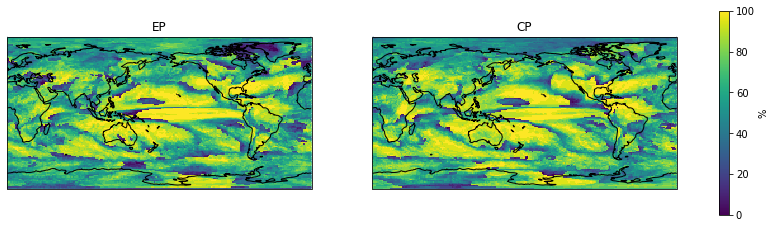

In [38]:
fig = plt.figure(figsize = (15,5)) 
axs = []
ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
im = EP_percent.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP')
axs.append(ax)
ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
im = CP_percent.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
cbar.ax.set_ylabel('%', fontsize=10)

#plt.savefig('model_agreement_precip_eof', bbox_inches='tight', dpi=300)